In [1]:
# Import Libraries
# =========================================================

## BUILT-IN IMPORTS
import warnings
from itertools import combinations
from collections import Counter, defaultdict

## DATA MANIPULATION IMPORTS
import numpy as np
import pandas as pd

## VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

## SKLEARN
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## XGBOOST
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier

## SHAP
import shap

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 500)
plt.rcParams["savefig.bbox"] = "tight"

In [2]:
def missing_summary(df):
    has_non = 0
    for column in df.columns:
        total_values = len(df)
        missing_values = df[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)
        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    if has_non == len(df.columns):
        print("Provided dataframe does not have any missing values.")
        
#############################################################
## my 5 minutes of extreme sillyness
def print_formatted_word(word):
    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)

In [3]:
df = pd.read_csv("../data/Bobs_df_semi_clean.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

In [4]:
missing_summary(df)

df["salary"] - Total values: 5962924, Missing values: 1512103 (25.36%)
df["salary_LN"] - Total values: 5962924, Missing values: 1512103 (25.36%)


In [5]:
product_revenue_map = {"short_term_deposit": 60, "loans": 40, "mortgage": 40, "funds": 60, "securities": 60, "long_term_deposit": 60, "credit_card": 40, "pension_plan": 60, "payroll_account": 10, "emc_account": 10, "debit_card": 40, "em_account_p": 10, "em_acount": 10}

products = list(product_revenue_map.keys())

In [6]:
## removing deceased customers and respective feature
df = df[df["deceased"] == 0]
df.drop("deceased", axis = 1, inplace = True)

## we will focus on customers registed and resident in Spain (ES)
df = df[df["country_id"] == "ES"]
df.drop("country_id", axis = 1, inplace = True)

## ultimately we will only be looking at users who have been active in the last 3 months, so we can drop all users who are users for less than 3 months
#df = df[df["entry_date"] <= "2019-03-01"]

## dropping entry date as we're only interested in users who have been active recently and we only have data for the past 17 months. What happened before we do not know.
#df.drop("entry_date", axis = 1, inplace = True)

## also dropping "segment" and "gender" features for trust and ethics reasons
df.drop(["Male", "segment"], axis = 1, inplace = True)

## and dropping "salary" features, as we have too many missing values and values do not seem realistic (way above any reasonable salary)
df.drop(["salary", "salary_LN"], axis = 1, inplace = True)

## finally dropping "active_customer" feature as we're only looking into users with active products. We assume that all users with active prodcuts are active customers.
df.drop("active_customer", axis = 1, inplace = True)

df.shape

(5959602, 21)

In [7]:
## creating revenue features
df_product = df[products]
revenues = np.array([product_revenue_map[f] for f in products])
df["total_revenue"] = (df_product * revenues).sum(axis = 1)
df_user_revenue = df.groupby("pk_cid")["total_revenue"].sum().reset_index()
df = pd.merge(df, df_user_revenue, on = "pk_cid", how = "left")

df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

In [8]:
## adding revenue class feature
revenue_classes_dict = {
    "None": (-1, 0),
    "Micro": (1, 50),
    "Low": (51, 170),    
    "mid": (171, 849),
    "upper": (850, 1200),
    "high": (1201, 10000)}

df["revenue_class"] = df["revenue_total"].apply(
    lambda x: next(
    (cat for cat, range in revenue_classes_dict.items() if range[0] <= x <= range[1])))

In [9]:
# removing customers with zero revenue as we cannot make conclusions about purchase and tenure behavior
df = df[df["revenue_class"] != "None"]
df.shape

(4990444, 24)

In [10]:
df["pk_cid"].nunique()

350229

In [11]:
df

,pk_cid,pk_partition,age,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,region,revenue_month,revenue_total,revenue_class
0,1375586,2018-01-28,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-12,KHL,Malaga,10,330,mid
1,1050611,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,Ciudad Real,10,170,Low
2,1050612,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,Ciudad Real,10,170,Low
3,1050613,2018-01-28,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-08-10,KHD,Zaragoza,60,120,Low
4,1050614,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,Zaragoza,10,170,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959597,1166765,2019-05-28,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,Zaragoza,10,170,Low
5959598,1166764,2019-05-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,La Rioja,10,210,mid
5959599,1166763,2019-05-28,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,Zaragoza,10,170,Low
5959600,1166789,2019-05-28,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,Zaragoza,10,170,Low


In [12]:
def unique_customer_df(data, product_list):

    prod_str_DF = pd.DataFrame(index = data["pk_cid"].unique())
    revenue_total = data.groupby("pk_cid")["revenue_total"].max()
    prod_str_DF = pd.concat([prod_str_DF, revenue_total], axis = 1)
    age = data.groupby("pk_cid")["age"].max()
    prod_str_DF = pd.concat([prod_str_DF, age], axis = 1)

    for product in product_list: 
        data[product] = data[product].astype(str)
        temp_SERIES = data.groupby("pk_cid")[product].sum()
        prod_str_DF = pd.concat([prod_str_DF, temp_SERIES], axis = 1)

    prod_str_DF = prod_str_DF[prod_str_DF["debit_card"].apply(len) >= 3]
    
    return prod_str_DF

In [13]:
stringed_DF = unique_customer_df(df, products)
stringed_DF

,revenue_total,age,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
1375586,330,36,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,11111111111111111
1050611,170,24,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
1050612,170,23,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
1050613,120,23,11000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000
1050614,170,24,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017056,30,34,000,000,000,000,000,000,000,000,000,011,000,000,001
1014969,10,46,000,000,000,000,000,000,000,000,000,000,000,000,100
1082677,100,28,000,000,000,000,000,000,000,000,000,000,011,000,011
1035063,60,33,000,000,000,000,000,000,000,000,000,000,001,000,011


In [14]:
# retention per product (total number of active months)
# retention / activity time per product (total number of active months / total number of months)
# recency per product (months past since latest activation)

stringed_DF["TARGET"] = stringed_DF["pension_plan"].apply(lambda x: 1 if "01" in x else 0)
stringed_DF["active_months"] = stringed_DF["loans"].apply(lambda s: len(s))

for product in products:
    stringed_DF[product + "_tenure"] = stringed_DF[product].apply(
        lambda s: sum([int(i) for i in s]))
    stringed_DF[product + "_tenure_rate"] = stringed_DF[product + "_tenure"] / len(df[product][0])
    stringed_DF[product + "_last_act"] = stringed_DF[product].apply(
        lambda s: -1 if "1" in s and s.rfind("01") == -1 else len(s) - s.rfind("01") - 2 if s.rfind("01") != -1 else 999999)

stringed_DF.drop(products, axis = 1, inplace = True)
stringed_DF.drop(["pension_plan_tenure", "pension_plan_tenure_rate", "pension_plan_last_act"], axis = 1, inplace = True)

In [15]:
stringed_DF["TARGET"].value_counts()

0    322442
1     23070
Name: TARGET, dtype: int64

In [16]:
stringed_DF

,revenue_total,age,TARGET,active_months,short_term_deposit_tenure,short_term_deposit_tenure_rate,short_term_deposit_last_act,loans_tenure,loans_tenure_rate,loans_last_act,mortgage_tenure,mortgage_tenure_rate,mortgage_last_act,funds_tenure,funds_tenure_rate,funds_last_act,securities_tenure,securities_tenure_rate,securities_last_act,long_term_deposit_tenure,long_term_deposit_tenure_rate,long_term_deposit_last_act,credit_card_tenure,credit_card_tenure_rate,credit_card_last_act,payroll_account_tenure,payroll_account_tenure_rate,payroll_account_last_act,emc_account_tenure,emc_account_tenure_rate,emc_account_last_act,debit_card_tenure,debit_card_tenure_rate,debit_card_last_act,em_account_p_tenure,em_account_p_tenure_rate,em_account_p_last_act,em_acount_tenure,em_acount_tenure_rate,em_acount_last_act
1375586,330,36,0,17,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,4,4.00,0,0,0.00,999999,17,17.00,-1
1050611,170,24,0,17,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,17,17.00,-1
1050612,170,23,0,17,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,17,17.00,-1
1050613,120,23,0,14,2,2.00,-1,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999
1050614,170,24,0,17,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,17,17.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017056,30,34,0,3,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,2,2.00,1,0,0.00,999999,0,0.00,999999,1,1.00,0
1014969,10,46,0,3,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,1,1.00,-1
1082677,100,28,0,3,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,2,2.00,1,0,0.00,999999,2,2.00,1
1035063,60,33,0,3,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,0,0.00,999999,1,1.00,0,0,0.00,999999,2,2.00,1


In [17]:
X = stringed_DF.drop(["TARGET"], axis = 1)
y = stringed_DF["TARGET"]

train, test, target, target_test = train_test_split(
    X, y, test_size = 0.3)

split_data_dict = {
    "TRAINING": [train, target],
    "TESTING": [test, target_test]}

print("Train:", train.shape, "| Target Mean:", target.mean())
print("Test:", test.shape, "| Target Mean:", target_test.mean())

Train: (241858, 39) | Target Mean: 0.06655558220112628
Test: (103654, 39) | Target Mean: 0.06727188531074536


In [18]:
XGB_model = XGBClassifier(
    max_depth = 4,
    random_state = 42,
    learning_rate = 0.002,
    colsample_bylevel = 0.5,
    verbosity = 0,
    n_jobs = -1)

XGB_model.fit(train, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.002, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

______________________ SCORES & EVALUATIONS _______________________________

###################### TRAINING ###########################################
Accuracy: 0.98203 | Precision: 0.84043 | Recall: 0.9011 | F1_Score: 0.86971
TN = 223007 | FN = 1592 | TP = 14505 | FP = 2754
Positive prediction value: 84.04% | Negative prediction value: 99.29%

###################### TESTING ############################################
Accuracy: 0.98209 | Precision: 0.84347 | Recall: 0.90105 | F1_Score: 0.87131
TN = 95515 | FN = 690 | TP = 6283 | FP = 1166
Positive prediction value: 84.35% | Negative prediction value: 99.28%

###################### CROSS-VALIDATION ###################################
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0            0.98           0.00           0.98          0.00
1            0.99           0.00           0.99          0.00
2            0.99           0.00           0.99          0.00
3            0.99           0.00           0.99          

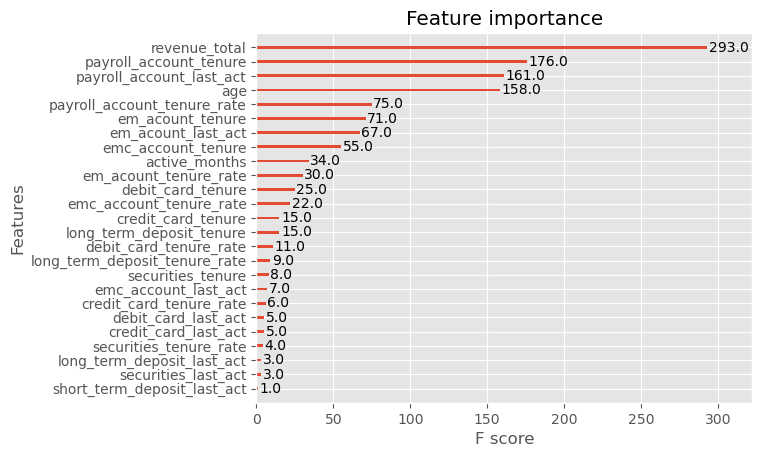

In [19]:
#print_formatted_word("SCORES & EVALUATIONS")
print("______________________ SCORES & EVALUATIONS _______________________________\n")

for data in split_data_dict.items():

    pred = XGB_model.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)

    probs = XGB_model.predict_proba(data[1][0])[:, 1]
    probs_mean = round(probs.mean()* 100, 2) 
    auc_score = roc_auc_score(data[1][1], probs)
    fpr, tpr, thresholds = roc_curve(data[1][1], probs)

    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)
    
    
    print_formatted_word(data[0])
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%\n")

data_dmatrix = xgb.DMatrix(X, y)
xgb_cv = cv(
    dtrain = data_dmatrix, 
    params = XGB_model.get_params(), 
    nfold = 3,
    num_boost_round = 50, 
    early_stopping_rounds = 10, 
    metrics = "auc", 
    as_pandas = True, 
    seed = 42)

print_formatted_word("CROSS-VALIDATION")
  
print(xgb_cv.head())

xgb.plot_importance(XGB_model)
plt.show()

In [22]:
apply_DF = stringed_DF[stringed_DF["TARGET"] == 0]
probs_apply = XGB_model.predict_proba(apply_DF)
probs_apply

ValueError: Feature shape mismatch, expected: 39, got 40

In [20]:
#data[1][0]